import torch
from torch import nn

In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cpu'

In [9]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.layers = nn.Sequential(nn.Linear(1, 30), nn.BatchNorm1d(30), nn.Sigmoid()) 
                                    #nn.Linear(5, 5), nn.BatchNorm1d(5), nn.ReLU(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.ReLU(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.ReLU(),
                                    #nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid())
        
        self.dist_head = nn.Sequential(nn.Linear(30, 2))
        #self.reg_head = nn.Sequential(nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid(), nn.Linear(5, 1), nn.Sigmoid())
        
    def forward(self, x):
        x = self.layers(x)
        return self.dist_head(x)#, self.reg_head(x)

In [10]:
data = torch.rand((100, 100), device=device)
data[data < 0.99] = 0
data *= 1000

In [11]:
data[10:45, 0:15] = torch.rand((35, 15), device=device) * 1000
data[30:90, 30:85] = torch.rand((60, 55), device=device) * 1000
data[85:95, 85:95] = torch.rand((10, 10), device=device) * 1000
# data /= data.max()

In [20]:
epochs = 5000
start_point = torch.tensor(0.0, device=device)
end_point = torch.tensor(1.0, device=device)

model = Regressor()
reg_loss = nn.L1Loss()
optimizer = optim.Adam(model.parameters())
optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
model = model.to(device)

w =  data.shape[1]
delta = 1 / data.shape[0]
t = torch.linspace(start=0, end=1, steps=data.shape[0], device=device)[..., None]
# t = torch.cat([t[..., None], t[..., None]], dim=1)
loss_history = []

for epoch in range(epochs):
    
    for _ in range(10):
        optimizer.zero_grad()
        output_d = model(t)
        dis_norm =  torch.distributions.Normal(output_d[:, 0], output_d[:, 1])
        s = dis_norm.rsample()
        output_y = s

        broad_loss = torch.abs(output_y[0] - start_point) + torch.abs(output_y[-1] - end_point)

        broad_loss.backward()
        optimizer.step()
    
    optimizer.zero_grad()
    output_d = model(t)
    dis_norm =  torch.distributions.Normal(output_d[:, 0], output_d[:, 1])
    loss = 0
    
    for _ in range(10):
        s = dis_norm.rsample()
        output_y = s
        delta_y = output_y[1:] - output_y[:-1]
    
        index = torch.tensor(output_y.clone().detach().clamp(0, 1 - 1 / w) * w, requires_grad=False, dtype=torch.long, device=device)
        z = torch.gather(data, 1, index[..., None])
        delta_z = z[1:] - z[:-1]
    
        length = torch.sqrt(delta ** 2 + delta_y ** 2 + delta_z ** 2).mean()
        loss += length
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())

/home/robo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


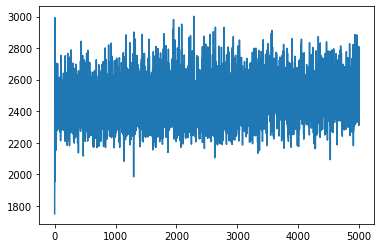

In [21]:
plt.plot(loss_history)

In [22]:
output_y = dis_norm.sample()
output_y[0], output_y[-1]

(tensor(-0.0056), tensor(1.0047))

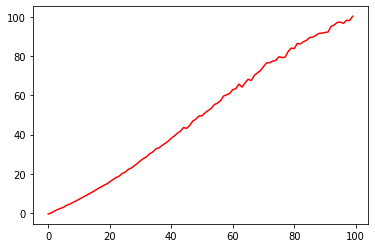

In [23]:
plt.plot(output_y.detach().cpu().numpy() * w, 'r')

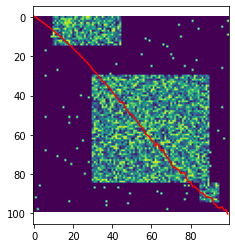

In [24]:
plt.imshow(data.cpu().numpy().transpose(1, 0))
plt.plot(output_y.detach().cpu().numpy() * w, 'r')

In [25]:
plt.close()

In [26]:
dis_norm.mean, dis_norm.stddev

(tensor([-0.0056,  0.0011,  0.0081,  0.0152,  0.0224,  0.0298,  0.0374,  0.0451,
          0.0529,  0.0610,  0.0691,  0.0775,  0.0860,  0.0947,  0.1035,  0.1124,
          0.1216,  0.1309,  0.1403,  0.1499,  0.1596,  0.1695,  0.1796,  0.1897,
          0.2001,  0.2105,  0.2211,  0.2318,  0.2427,  0.2537,  0.2648,  0.2760,
          0.2873,  0.2987,  0.3102,  0.3219,  0.3336,  0.3454,  0.3572,  0.3692,
          0.3812,  0.3933,  0.4054,  0.4176,  0.4298,  0.4420,  0.4543,  0.4666,
          0.4789,  0.4912,  0.5036,  0.5159,  0.5282,  0.5405,  0.5527,  0.5650,
          0.5771,  0.5893,  0.6014,  0.6134,  0.6253,  0.6372,  0.6490,  0.6608,
          0.6724,  0.6839,  0.6954,  0.7067,  0.7180,  0.7291,  0.7401,  0.7509,
          0.7617,  0.7723,  0.7828,  0.7931,  0.8033,  0.8134,  0.8233,  0.8331,
          0.8427,  0.8522,  0.8615,  0.8707,  0.8797,  0.8885,  0.8972,  0.9057,
          0.9141,  0.9223,  0.9304,  0.9383,  0.9460,  0.9536,  0.9610,  0.9683,
          0.9754,  0.9824,  

In [27]:
length

tensor(231.6882, grad_fn=<MeanBackward0>)